In [1]:
import numpy as np
import torch 
import pandas as pd
import pickle
import time
import sys
import itertools
import pandas as pd

import matplotlib.pyplot as plt
from tueplots import axes, bundles
plt.rcParams.update({"figure.dpi": 150})

# bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)
plt.rcParams.update(bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)
)

In [2]:
names = {"narea": "Narea", "sla": "SLA", "ps": "PLSR_SLA_Sorghum", "pn": "FS_PLSR_Narea"}

## Quick Plot:
Plot your result from a single experiment. Just replace the file path with the corresponding run.

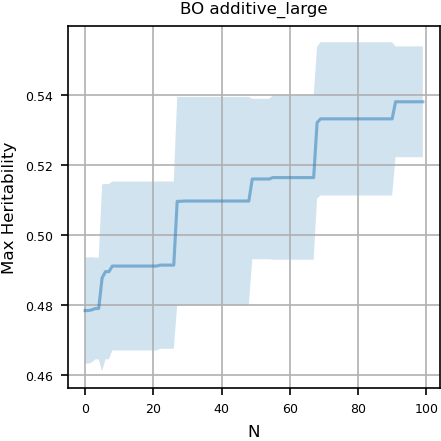

In [26]:
#plotting a single experiment
trait = "narea"
run_name = "additive_large" 
base_path = f"./output/BO_runs/{run_name}"
seeds = [0,1,2,3,4]

with plt.rc_context(bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)):
    fig, ax = plt.subplots(1,1, figsize=(3,3))

    # Get data function
    def getCol(col_name):
        _results = [pd.read_csv(f"{base_path}/result_{seed}.npy", encoding='utf-8')[col_name] for seed in seeds]
        _results = [np.array(_results[i]) for i in range(0,len(_results))]
        return _results

    n = getCol("n")[0]
    best = getCol("best")
    #train_loss = getCol("train_loss")
    #val_loss = getCol("val_loss")

    # Define linePlot function with linestyle parameter
    def linePlot(ax, _results, label, linestyle):
        mean, var = np.mean(_results, axis=0), np.std(_results, axis=0)
        ax.plot(n, mean, label=label, linestyle=linestyle, alpha=0.5)
        ax.fill_between(n, mean - var,  mean + var, alpha=0.2)
        return
    
    linePlot(ax, best, label=run_name , linestyle='-')
    #linePlot(ax, train_loss, label=f"{run_name} train", linestyle='-')  # Solid line for training data
    #linePlot(ax, val_loss, label=f"{run_name} validation", linestyle='--')  # Dashed line for validation data

    ax = ax
    ax.grid(True)
    ax.set_title(f"BO {run_name}") 
    ax.set_xlabel("N") 
    ax.set_ylabel("Max Heritability")
    #ax.legend(loc="lower right")

plt.show()

## Full Benchmarks: 

In [42]:
#For plotting a full sweep, double check that data files exist which you want to plot
seeds = 5
traits = ["narea"]
base_path = f"./output/BO_runs"

for acq_name in ["EI", "PI", "UCB-0.1", "UCB-0.2", "UCB-0.5"]:
    for kernel_name in ["matern52", "matern32", "rbf", "matern12"]:
        for trait in traits:
            trait = trait.lower()
            try:
                _results = [pd.read_csv(f"{base_path}/{trait}/{kernel_name}_{acq_name}/result_{seed}.npy", encoding='utf-8') for seed in range(seeds)]
            except Exception as e:
                print(e)

[Errno 2] No such file or directory: './output/BO_runs/narea/matern52_UCB-0.1/result_0.npy'
[Errno 2] No such file or directory: './output/BO_runs/narea/matern32_UCB-0.1/result_0.npy'
[Errno 2] No such file or directory: './output/BO_runs/narea/rbf_UCB-0.1/result_0.npy'
[Errno 2] No such file or directory: './output/BO_runs/narea/matern12_UCB-0.1/result_0.npy'
[Errno 2] No such file or directory: './output/BO_runs/narea/matern32_UCB-0.5/result_0.npy'
[Errno 2] No such file or directory: './output/BO_runs/narea/rbf_UCB-0.5/result_0.npy'
[Errno 2] No such file or directory: './output/BO_runs/narea/matern12_UCB-0.5/result_0.npy'


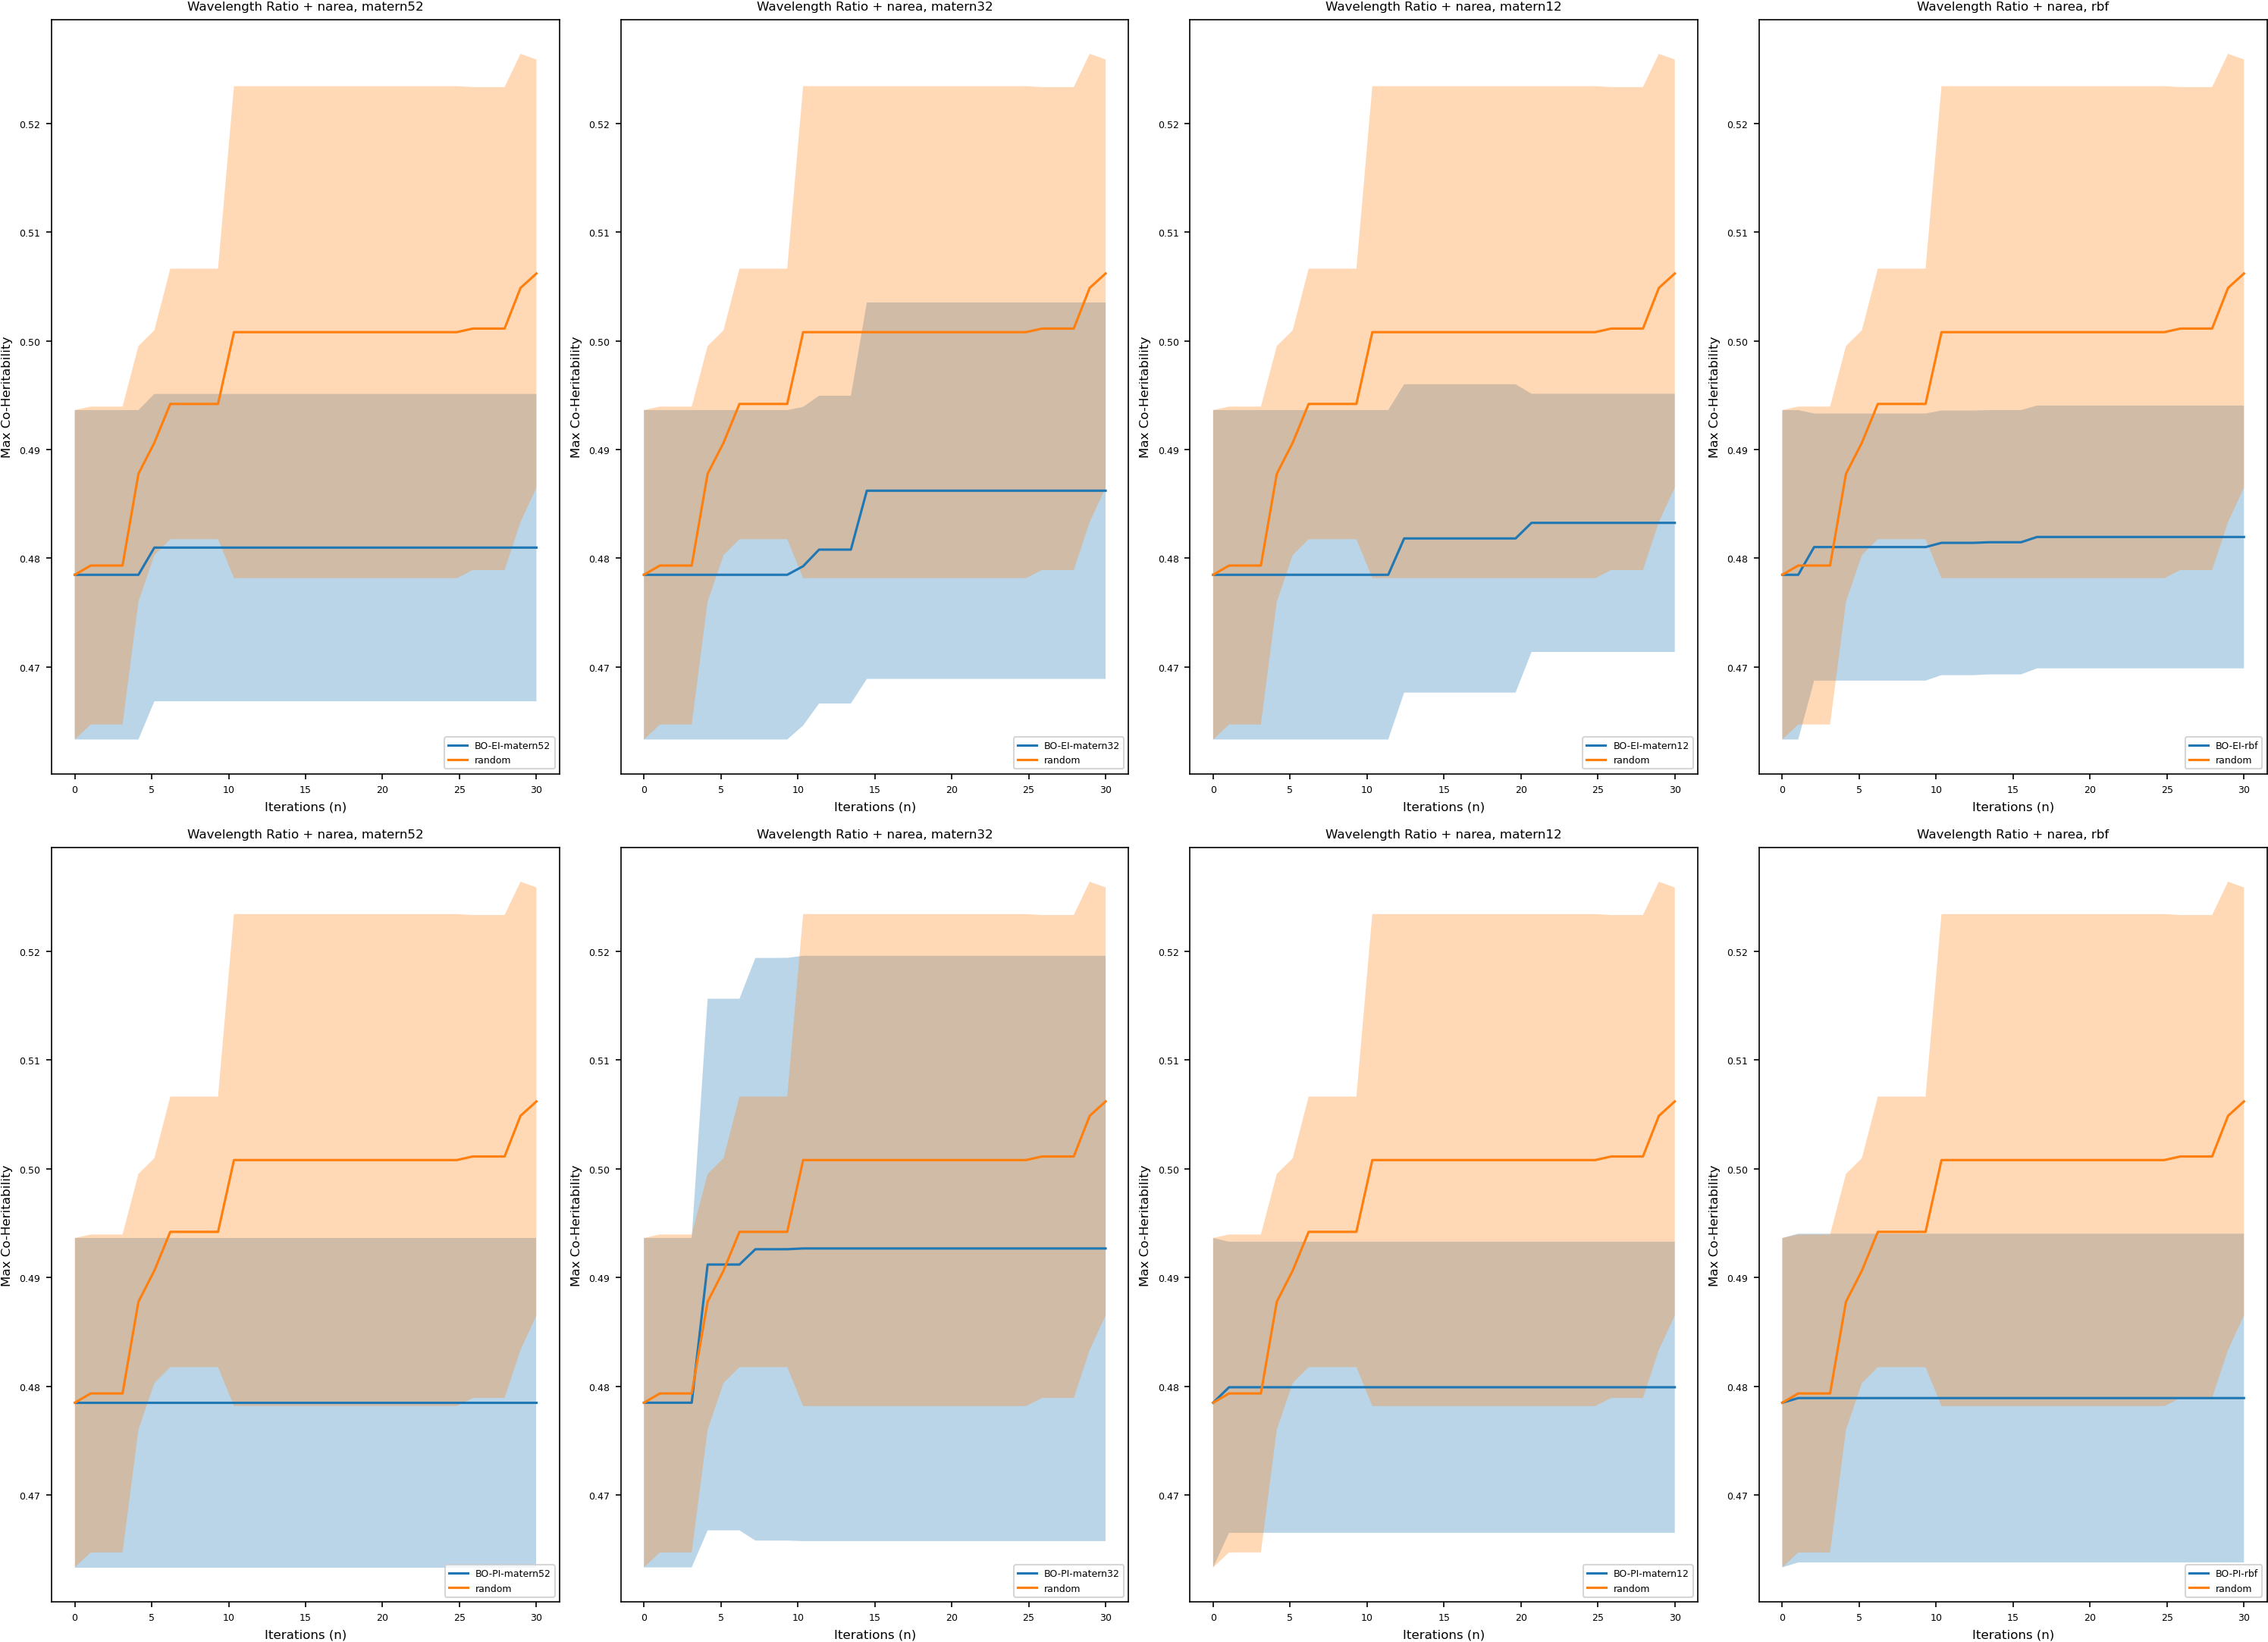

In [40]:
trait = "narea"
base_path = f"./output/BO_runs"
seeds = [0,1,2,3,4]

kernels = ["matern52", "matern32", "matern12", "rbf"]
acqs = ["EI", "PI"]#, "UCB-0.5"]#"UCB-0.1", "UCB-0.2"]


alpha=0.2
fig, axs = plt.subplots(len(acqs), len(kernels), figsize=(20, 14.5))
color_dict = {"EI": 'Pink', "PI": 'Blue', "KG": 'Green', 
              "UCB": 'Orange', "UCB-0.1": 'Red', "UCB-0.2": 'Green', "UCB-0.5": 'Orange'}

#BAYESIAN OPTIMIZATION
for a, acq_name in enumerate(acqs):
    for k, kernel_name in enumerate(kernels):
        botorch_results = [pd.read_csv(f"{base_path}/{trait}/{kernel_name}_{acq_name}/result_{seed}.npy", encoding='utf-8')["best"] for seed in seeds]
        botorch_results = [np.array(botorch_results[i]) for i in range(0,len(botorch_results))]
        mean, var = np.mean(botorch_results, axis=0), np.std(botorch_results, axis=0)
        x_axis = np.linspace(0, len(mean), len(mean))

        color = color_dict[acq_name]
        axs[a, k].plot(x_axis, mean, label= f"BO-{acq_name}-{kernel_name}") #, color=color)
        axs[a, k].fill_between(x_axis, mean - var,  mean + var, alpha=0.3) #, color=color)

        #plot random
        botorch_results = [pd.read_csv(f"{base_path}/{trait}/random/result_{seed}.npy", encoding='utf-8')["best"] for seed in seeds]
        botorch_results = [np.array(botorch_results[i]) for i in range(0,len(botorch_results))]
        mean, var = np.mean(botorch_results, axis=0), np.std(botorch_results, axis=0)
        axs[a, k].plot(x_axis, mean, label= f"random") #, color="black")
        axs[a, k].fill_between(x_axis, mean - var,  mean + var, alpha=0.3) #, color="black")

        # #graph elements
        # plt.plot([actual_max[trait]]*its ,linestyle='dashed', label="Best Co-heritabilty")
        # plt.plot ([top_01[trait]]*its ,linestyle='dashed', label="Top 1%")

        axs[a, k].set_title(f"Wavelength Ratio + {trait}, {kernel_name}") 
        axs[a, k].set_xlabel("Iterations (n)") 
        axs[a, k].set_ylabel("Max Co-Heritability")
        axs[a, k].legend(loc="lower right")
        #axs[a, k].set_ylim(0,1)
plt.show()